# Определение перспективного тарифа для телеком-компании

Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Изучение данных.

Для начала импортируем все библиотеки, которые могут нам пригодиться:

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

#### Таблица users (информация о пользователях)

Прочитаем файл и сохраним его в переменной users:

In [2]:
users = pd.read_csv('/datasets/users.csv', index_col=0)
users.head(10)

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart


Подгрузим информацию о таблице:

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         500 non-null    int64 
 1   churn_date  38 non-null     object
 2   city        500 non-null    object
 3   first_name  500 non-null    object
 4   last_name   500 non-null    object
 5   reg_date    500 non-null    object
 6   tariff      500 non-null    object
dtypes: int64(1), object(6)
memory usage: 31.2+ KB


В таблице 500 строк, она содержит информацию о 500 клиентах: 
user_id — уникальный идентификатор пользователя - тип данных int64 - всё логично;
first_name — имя пользователя - тип данных object - всё логично;
last_name — фамилия пользователя - тип данных object - всё логично;
age — возраст пользователя (годы) - тип данных int64 - всё логично;
reg_date — дата подключения тарифа (день, месяц, год) - тип данных object - стоит поменять на формат "дата и время";
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных) - тип данных object - стоит поменять на формат "дата и время";
city — город проживания пользователя - тип данных object - всё логично;
tariff — название тарифного плана - тип данных object - всё логично.
Названия столбцов не вызывают вопросов - всё красиво записано "змеииным" регистом. Предлагаю проверить таблицу на явные дубликаты и пропуски:

In [4]:
users.duplicated().sum()

0

In [5]:
users.isna().sum()

age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Явных дубликатов нет, пропуски только в столбце churn_date — дата прекращения пользования тарифом - значит клиент тарифом пользоваться не прекратил. Такие пропуски мы заполнять не можем, значит оставим их. На всякий случай хочу посмотреть уникальные значения в столбце city, чтобы проверить таблицу на неявные будликаты:

In [6]:
users['city'].value_counts().head(10)

Москва              99
Санкт-Петербург     39
Новосибирск         16
Омск                14
Казань              14
Уфа                 12
Набережные Челны    11
Екатеринбург        11
Ульяновск           11
Краснодар           11
Name: city, dtype: int64

Неявных дубликатов я тоже не нашла. Тогда отработаем проблему со столбцами churn_date и reg_date, поменяем тип данных этих столбцов на дату и время:

In [7]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   age         500 non-null    int64         
 1   churn_date  38 non-null     datetime64[ns]
 2   city        500 non-null    object        
 3   first_name  500 non-null    object        
 4   last_name   500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 31.2+ KB


Мы обработали первую таблицу, проверили на пропуски и дубликаты, изменили типы данных в необходимых случаях. Продолжим работу.

#### Таблица calls (информация о звонках)

Прочитаем файл и сохраним его в переменной calls:

In [8]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Подгрузим информацию об этой таблице:

In [9]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице 202607 строк и 4 колонки: 
id — уникальный номер звонка - тип данных object - это нормально;
call_date — дата звонка - тип данных object - надо менять на "дата и время";
duration — длительность звонка в минутах -тип данных float64 - это нормально;
user_id — идентификатор пользователя, сделавшего звонок - тип данных float64 - это нормально. 
Названия столбцов не вызывают вопросов - всё красиво записано "змеииным" регистом. Предлагаю проверить таблицу на явные дубликаты и пропуски:

Мы должны учесть, что «Мегалайн» всегда округляет секунды до минут, значит нам тоже надо это сделать, чтобы дальнейшие подсчеты были верными:

In [10]:
calls['duration'] = np.ceil(calls['duration'])
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


In [11]:
calls.duplicated().sum()

0

In [12]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

Ни пропусков, ни явных дубликатов не обнаружено. Изменим тип данных в столбце call_date:

In [13]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Таблица calls проверена и готова к анализу.

#### Таблица messages (информация о сообщениях)

Прочитаем файл и сохраним его в переменной messages:

In [14]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Подгрузим информацию об этой таблице:

In [15]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице всего три колонки: 
id — уникальный номер сообщения - тип данных object - это нормально;
message_date — дата сообщения  тип данных object - стоит поменять на "дата и время";
user_id — идентификатор пользователя, отправившего сообщение - тип данных int64 - это нормально.
Названия столбцов написаны в "змеином" регистре, они ясны, всё выглядит "стильно".
Проверим таблицу на явные дубликаты и пропуски в столбцах:

In [16]:
messages.duplicated().sum()

0

In [17]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

Дубликатов нет, пропусков тоже нет. Изменим тип данных в столбце message_date:

In [18]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Тип данных заменили. Таблица готова к дальнейшей работе.

#### Таблица internet (информация об интернет-сессиях)

Прочитаем файл и сохраним его в переменной internet:

In [19]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Теперь посмотрим информацию о таблице:

In [20]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Названия столбцов написаны в "змеином" регистре, в этом смысле стиль соблюдён. 
Первый и второй столбец полностью дублируют друг друга. Можно первый исключить из таблицы - так она станет читабельнее.
Что касается самих функциональных столбцов, то они характеризуются следующим образом:
id — уникальный номер сессии - тип данных object - это подходит;
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах) - тип данных float64 - это подходит;
session_date — дата интернет-сессии - тип данных object - стоит поменять на дату и время;
user_id — идентификатор пользователя тип данных int64 - это подходит.
Сначала уберем ненужный столбец, потом приведем в порядок тип данных столбца session_date, затем проверим таблицу на явные дубликаты и пропуски.

In [21]:
internet = internet[['id','mb_used','session_date','user_id']]
internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [22]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [23]:
internet.duplicated().sum()

0

In [24]:
internet.isna().sum()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Теперь снова выгрузим информацию о таблице:

In [25]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


Дубликатов нет, пропусков тоже нет. Типы данных приведены в порядок. 

#### Таблица tariffs (информация о тарифах)

Прочитаем файл и сохраним его в переменной  tariffs:

In [26]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [27]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Таблица содержит следующие данные по 2-м тарифам (т.е. строк всего 2):
ariff_name — название тарифа - тип данных object - это нормально;
Все остальные столбцы имеют тип данных int64, что полностью соответствует их содержанию: 
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)
Пропусков и дубливатов нет - это видно невооруженным глазом.
Названия слобцов стилистически верны - никаких дополнительных манипуляций с таблицей проводить не надо.


### Подготовка данных.

#### Свод данных о звонках.

Таблица calls содержит данные за 2018 год. Нам будет необходимо посчитать для каждого пользователя количество звонков по месяцам. Предлагаю начать с того, что добавить столбец с информацией о месяце:

In [28]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.head(10)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
5,1000_5,2018-11-02,0.0,1000,11
6,1000_6,2018-10-18,0.0,1000,10
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9
9,1000_9,2018-08-15,0.0,1000,8


Теперь сгруппируем данные по клиентам по месяцам и назовём эту таблицу calls_info_sum. Эта таблица будет показывать суммарную длительность звонков:

In [29]:
calls_info_sum = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
calls_info_sum

,user_id,month,duration
0,1000,5,159.0
1,1000,6,172.0
2,1000,7,340.0
3,1000,8,408.0
4,1000,9,466.0
...,...,...,...
3169,1498,10,247.0
3170,1499,9,70.0
3171,1499,10,449.0
3172,1499,11,612.0


А таблица calls_info_count будет показывать суммарное количество звонков:

In [30]:
calls_info_count = calls.groupby(['user_id', 'month'])['id'].count().reset_index()
calls_info_count

,user_id,month,id
0,1000,5,22
1,1000,6,43
2,1000,7,47
3,1000,8,52
4,1000,9,58
...,...,...,...
3169,1498,10,41
3170,1499,9,9
3171,1499,10,68
3172,1499,11,74


Теперь объединим эти две таблицы в одну:

In [31]:
calls_info = calls_info_sum.merge(calls_info_count, on=['user_id', 'month'], how='outer')
calls_info.head()

,user_id,month,duration,id
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58


Теперь у нас есть информация по каждому клиенту в разбивке по месяцам о количестве звонков и их продолжительности, которая хранится в таблице calls_info.

#### Свод данных о сообщениях.

Таблица messages содержит данные за 2018 год. Нам будет необходимо посчитать для каждого пользователя количество сообщений по месяцам. Предлагаю начать с того, что добавить столбец с информацией о месяце:

In [32]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.head(10)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
5,1000_5,2018-06-20,1000,6
6,1000_6,2018-11-19,1000,11
7,1000_7,2018-10-29,1000,10
8,1000_8,2018-06-25,1000,6
9,1000_9,2018-12-18,1000,12


Теперь сгруппируем данные по клиентам по месяцам и назовём эту таблицу messages_info:

In [33]:
messages_info = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages_info.head()

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Теперь у нас есть информация по каждому клиенту в разбивке по месяцам о количестве сообщений, которая хранится в таблице messages_info.

#### Свод данных об интернет-трафике.

Таблица internet содержит данные за 2018 год. Нам будет необходимо посчитать для каждого пользователя количество трафика по месяцам. Предлагаю начать с того, что добавить столбец с информацией о месяце:

In [34]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet.head(10)

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
5,1000_5,399.97,2018-10-02,1000,10
6,1000_6,540.08,2018-09-07,1000,9
7,1000_7,415.70,2018-07-11,1000,7
8,1000_8,505.40,2018-10-08,1000,10
9,1000_9,345.54,2018-09-03,1000,9


Теперь сгруппируем данные по клиентам по месяцам и назовём эту таблицу internet_info

In [35]:
internet_info = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
internet_info

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


Теперь мы можем посмотреть, какой клиент использовал какой трафик в каждом из месяцев отчетного года, используя новую таблицу internet_info. Остался один нерешеный вопрос. Оператор округляет трафик до ГБ при расчете оплаты. Значит нам необходимо привести данные в столбце mb_used к такому формату, чтобы расчеты были верны. Предлагаю изменить единицу измерения столбца: вместо Мб пусть будет ГБ. Сделать это просто - нужно разделить значения столбца на 1000ю Затем округим значения до большего целого:

In [36]:
internet_info['mb_used'] = internet_info['mb_used']/1024
internet_info['mb_used'] = np.ceil(internet_info['mb_used'])
internet_info.head()

,user_id,month,mb_used
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0


#### Объединение данных.

В итоге у нас есть 5 таблиц, которые содержат необходимы нам данные:
1. users - дает информацию о том, какой тариф соответствует каждому пользователю. 
2. calls_info - дает информацию о том, сколько звонков и какой длительности совершает каждый клиент в разбивке по месяцам.
3. messages_info - дает информацию о том, сколько сообщений отправлял каждый клиент с разбивкой по месяцам.
4. internet_info - дает информацию о трафике
5. tariffs - дает информацию о стоимости всех вышеперечисленных услуг.

Предлагаю объединить данные из этих таблиц. Начнем с таблиц с данными о звонках, сообщениях и интернет-трафике:

In [37]:
information = calls_info.merge(messages_info, on=['user_id', 'month'], suffixes=('_calls', '_messages'), how='outer')
information.head()

,user_id,month,duration,id_calls,id_messages
0,1000,5,159.0,22.0,22.0
1,1000,6,172.0,43.0,60.0
2,1000,7,340.0,47.0,75.0
3,1000,8,408.0,52.0,81.0
4,1000,9,466.0,58.0,57.0


In [38]:
information = information.merge(internet_info, on=['user_id', 'month'], how='outer').reset_index()
information.head()

,index,user_id,month,duration,id_calls,id_messages,mb_used
0,0,1000,5,159.0,22.0,22.0,3.0
1,1,1000,6,172.0,43.0,60.0,23.0
2,2,1000,7,340.0,47.0,75.0,14.0
3,3,1000,8,408.0,52.0,81.0,14.0
4,4,1000,9,466.0,58.0,57.0,15.0


Теперь нужно добавить информацию о тарифе, который использует каждый клиент:

In [39]:
information = information.merge(users, on=['user_id'], how='outer')
information.head()

,index,user_id,month,duration,id_calls,id_messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,0.0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1.0,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,2.0,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,3.0,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,4.0,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Проверим, всё ли прошло гладко, осталось ди у нас 500 клиентов, как и было в самом начале:

In [40]:
information['user_id'].value_counts().count()

500

Теперь наша таблица содержит данные о тарифах и используемых услугах. Необходимо просчитать, сколько тратит на связь каждый клиент каждый месяц, чтобы проводить дальнейший анализ. У нас есть подробная информация о том, как считается стоимость услуг помимо абонентской платы. Заключим эту информацию в столбец expenses с помощью функции expenses:

В процессе написания фукции будем ссыласться на данные из таблицы tariffs:

In [41]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Очевидно нам надо преобразовать МБ в ГБ:

In [42]:
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included']/1024
tariffs['gb_per_month_included'] = np.ceil(tariffs['gb_per_month_included'])
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


In [43]:
def expenses_raw (raw):
    tariff = raw['tariff']
    calls = raw['duration']
    message = raw['id_messages'] 
    gbyte = raw['mb_used'] 
 
    if tariff == 'ultra':
        if calls >= tariffs.loc[1,'minutes_included']: 
            calls = (calls - tariffs.loc[1,'minutes_included']) * tariffs.loc[1,'rub_per_minute']
        else:
            calls = 0
 
        if message >= tariffs.loc[1,'messages_included']:
            message = (message-tariffs.loc[1,'messages_included']) * tariffs.loc[1,'rub_per_message']
        else:
            message = 0
 
        if gbyte >= tariffs.loc[1,'gb_per_month_included']:
                gbyte = (gbyte - tariffs.loc[1,'gb_per_month_included']) * tariffs.loc[1,'rub_per_gb']
        else:
            gbyte = 0
        return 1950 + calls + message + gbyte
 
    if tariff == 'smart':
        if calls >= tariffs.loc[0,'minutes_included']: 
            calls = (calls - tariffs.loc[0,'minutes_included']) * tariffs.loc[0,'rub_per_minute']
        else:
            calls = 0
 
        if message >= tariffs.loc[0,'messages_included']:
            message = (message - tariffs.loc[0,'messages_included']) * tariffs.loc[0,'rub_per_message']
        else:
            message = 0
 
        if gbyte >= tariffs.loc[0,'gb_per_month_included']:
                gbyte =(gbyte - tariffs.loc[0,'gb_per_month_included']) * tariffs.loc[0,'rub_per_gb']
        else:
            gbyte = 0
        return 550 + calls + message + gbyte
 
information['expenses'] = information.apply(expenses_raw, axis =1)
information.head()

,index,user_id,month,duration,id_calls,id_messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,expenses
0,0.0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
1,1.0,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
2,2.0,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
3,3.0,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
4,4.0,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0


Теперь у нас есть таблица information, которая содержит в себе данные о звонках, сообщениях, интернет-трафиках, тарифах и стоимостях услуг по каждому клиенту в разбивке по месяцам. Теперь мы сможем проанализировать эти данные.

### Анализ и описание данных

Предлагаю начать с того, что определить,  сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Для начала поделим нашу таблицу на клиентов, которые пользуются тарифом "Ультра" - назовем этот срез information_ultra и такрифом "Смарт" - назовем срез information_smart. Сравним сколько клиентов в каждом из срезов.

In [44]:
information_ultra = information.query('tariff == "ultra"')
information_ultra

,index,user_id,month,duration,id_calls,id_messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,expenses
0,0.0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
1,1.0,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
2,2.0,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
3,3.0,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
4,4.0,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205,3204.0,1473,9.0,NaN,NaN,19.0,17.0,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1950.0
3206,3205.0,1473,10.0,NaN,NaN,20.0,14.0,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1950.0
3207,3206.0,1473,11.0,NaN,NaN,14.0,22.0,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1950.0
3208,3207.0,1473,12.0,NaN,NaN,20.0,18.0,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1950.0


In [45]:
information_ultra['user_id'].value_counts().count()

149

In [46]:
information_smart = information.query('tariff == "smart"')
information_smart

,index,user_id,month,duration,id_calls,id_messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,expenses
8,8.0,1001,11.0,430.0,59.0,NaN,18.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1150.0
9,9.0,1001,12.0,414.0,63.0,NaN,14.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,550.0
10,10.0,1002,6.0,117.0,15.0,4.0,11.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,550.0
11,11.0,1002,7.0,214.0,26.0,11.0,18.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,1150.0
12,12.0,1002,8.0,289.0,42.0,13.0,20.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,1550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,3209.0,1489,9.0,NaN,NaN,32.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,950.0
3211,3210.0,1489,10.0,NaN,NaN,21.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,1550.0
3212,3211.0,1489,11.0,NaN,NaN,20.0,18.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,1150.0
3213,3212.0,1489,12.0,NaN,NaN,35.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,950.0


In [47]:
information_smart['user_id'].value_counts().count()

351

351 клиент с тарифом "Смарт" против 149 клиентов с тарифом "Ультра". Логично, тариф "Ультра" дороже. Теперь поработаем с каждой группой клиентов отдельно.

#### Ультра

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям тарифа "Ультра" в месяц.

##### Поговорим о минутах

Нам надо найти среднее количество звонков в нашем тарифе, рассчитать дисперсию, стандартное отклонение, посмотреть гистограмму и на основании этих данных сделать выводы о распределениях.

In [48]:
calls_ultra = information_ultra.groupby('month')['duration'].mean()
calls_ultra

month
1.0     428.111111
2.0     297.125000
3.0     489.648649
4.0     475.301887
5.0     534.250000
6.0     497.469136
7.0     564.397727
8.0     530.611650
9.0     558.882883
10.0    581.728814
11.0    562.364341
12.0    614.925373
Name: duration, dtype: float64

In [49]:
#calls_ultra.mean()

In [50]:
#varianse_calls_ultra = np.var(calls_ultra)
#varianse_calls_ultra                                  

<AxesSubplot:>

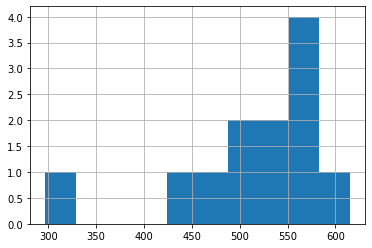

In [51]:
calls_ultra.hist(bins=10)

Из графика видно, что в среднем владельцы тарифа "Ультра" меньше всего звонят в феврале, январе, во воторой половине года количество звонков незначительно увеличивается. 

In [52]:
#standart_deviation_calls_ultra = np.std(calls_ultra)
#standart_deviation_calls_ultra

In [97]:
information_ultra.pivot_table(index= 'tariff', values= 'duration', aggfunc= ['mean', 'var','std'])

,mean,var,std
,duration,duration,duration
tariff,,,
ultra,545.451104,94203.418396,306.925754


Так же можно сделать вывод о том, что клиенты в этом тарифе никогда не выходят за пределы месячных лимитов по длительности звонков: в среднем они разговаривают 545 минут в месяц со стандартным отклонением в 306 минут, т.е. 3000 минут им не нужно. Возможно стоит пересмотреть тариф, чтобы клиент не подумал, что его хотят заставить платить за то, что он точно не использует, и не ушел к другому оператору.

##### Поговорим о сообщениях

Посмотрим, как клиенты тарифа "Ультра" пользуются сообщениями:

In [54]:
information_ultra['id_messages'].isna().sum()

191

191 клиент с пропусками в столбце сообщения, я уверена, что связано это с тем, что клиенты просто их не отправляют. Предлагаю их исключить из рассчета, чтобы без искажения посмотреть, как ведут себя оставшиеся 160. эти нули сильно искажают поведение остальных клиентов, так что из выборки их уберем.

In [55]:
information_ultra_use = information_ultra.dropna(subset = ['id_messages'])
information_ultra_use.head()

,index,user_id,month,duration,id_calls,id_messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,expenses
0,0.0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
1,1.0,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
2,2.0,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
3,3.0,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
4,4.0,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0


Теперь посмотрим, как вели себя те, кто всё же отправляет смс.

In [56]:
messages_ultra_use = information_ultra_use.groupby('month')['id_messages'].mean()

In [57]:
#messages_ultra_use.mean()

In [58]:
#varianse_messages_ultra = np.var(messages_ultra_use)
#varianse_messages_ultra 

<AxesSubplot:>

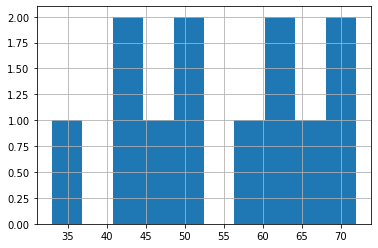

In [59]:
messages_ultra_use.hist(bins=10)

In [60]:
#standart_deviation_messages_ultra = np.std(messages_ultra_use)
#standart_deviation_messages_ultra

In [99]:
information_ultra_use.pivot_table(index= 'tariff', values= 'id_messages', aggfunc= ['mean', 'var','std'])

,mean,var,std
,id_messages,id_messages,id_messages
tariff,,,
ultra,61.161006,2109.659183,45.931026


Получается, что клиенты тарифа "Ультра" смс пользуются, за пределы лимитов тарифа не выходят - отправляют 61 сообщение в месяц со стандартным отклонением в 45 сообщений. Но очень много абонентов вообще сообщения не отправляют. 1000 сообщений в месяц им точно не нужно. Считаю, что нужно пересмотреть тариф, иначе у клиентов сложится впечатление, что они платят за услугу, которой точно не пользуются, и оператор их потеряет.

##### Поговорим об интернет-трафике

Посмотрим, как обстоят дела с интернет-трафиком в тарифе "Смарт". Мы помним, что в лимит тарифа входит 15 ГБ в месяц. Остальное нужно оплачивать дополнительно.

In [62]:
internet_ultra = information_ultra.groupby('month')['mb_used'].mean()
internet_ultra

month
1.0     13.222222
2.0     13.090909
3.0     17.648649
4.0     16.963636
5.0     19.666667
6.0     19.168675
7.0     20.733333
8.0     19.783019
9.0     19.412281
10.0    20.229508
11.0    19.954887
12.0    21.898551
Name: mb_used, dtype: float64

In [63]:
#internet_ultra.mean()

In [64]:
#varianse_internet_ultra = np.var(internet_ultra)
#varianse_internet_ultra  

<AxesSubplot:>

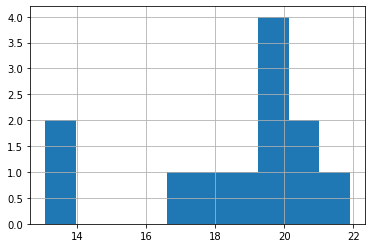

In [65]:
internet_ultra.hist(bins=10)

In [66]:
#standart_deviation_internet_ultra = np.std(internet_ultra)
#standart_deviation_internet_ultra

In [101]:
information_ultra.pivot_table(index= 'tariff', values= 'mb_used', aggfunc= ['mean', 'var','std'])

,mean,var,std
,mb_used,mb_used,mb_used
tariff,,,
ultra,19.694359,94.146734,9.702924


Получается, что абоненты не укладываются в лимиты тарифа - в среднем они используют 10 ГБ с очень маленьким стандартным отклонением.

#### Смарт

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям тарифа "Смарт" в месяц.

##### Поговорим о минутах

Посмотрим, как клиенты тарифа "Смарт" пользуются звонками.

In [68]:
calls_smart = information_smart.groupby('month')['duration'].mean()
calls_smart

month
1.0     203.852941
2.0     298.689655
3.0     390.051948
4.0     367.133929
5.0     387.361702
6.0     398.067485
7.0     408.353234
8.0     423.269231
9.0     430.266409
10.0    427.590444
11.0    436.647619
12.0    479.985119
Name: duration, dtype: float64

In [69]:
#calls_smart.mean()

In [70]:
#varianse_calls_smart = np.var(calls_smart)
#varianse_calls_smart  

<AxesSubplot:>

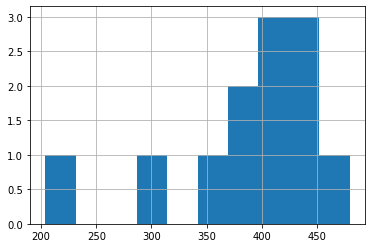

In [71]:
calls_smart.hist(bins=10)

In [72]:
#standart_deviation_calls_smart = np.std(calls_smart)
#standart_deviation_calls_smart

In [73]:
information_smart.pivot_table(index= 'tariff', values= 'duration', aggfunc= ['mean', 'var','std'])

,mean,var,std
,duration,duration,duration
tariff,,,
smart,419.062978,35844.189551,189.325618


Можно сделать вывод о том, что они, как и клиенты "Ультра" меньше всего разговаривают в январе и феврале. Однако иногда выходят за пределы месячного лимита - в среднем 419 минут со стандартным отклонением в 189 минут.

##### Поговорим о сообщениях

Для начала проверим, все ли клиенты вообще ползуются этой услугой - сама, как пользователь, могу сказать, что смс не пишу совсем.

In [74]:
information_smart['id_messages'].isna().sum()

308

Так и есть - пропусков много, избавимся от них, чтобы не искажать данные по тем, кто пользуется.

In [75]:
information_smart_use = information_smart.dropna(subset = ['id_messages'])
information_smart_use

,index,user_id,month,duration,id_calls,id_messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,expenses
10,10.0,1002,6.0,117.0,15.0,4.0,11.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,550.0
11,11.0,1002,7.0,214.0,26.0,11.0,18.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,1150.0
12,12.0,1002,8.0,289.0,42.0,13.0,20.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,1550.0
13,13.0,1002,9.0,206.0,36.0,4.0,17.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,950.0
14,14.0,1002,10.0,212.0,33.0,10.0,14.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3208.0,1489,8.0,NaN,NaN,17.0,11.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,550.0
3210,3209.0,1489,9.0,NaN,NaN,32.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,950.0
3211,3210.0,1489,10.0,NaN,NaN,21.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,1550.0
3212,3211.0,1489,11.0,NaN,NaN,20.0,18.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,1150.0


In [76]:
messages_smart_use = information_smart_use.groupby('month')['id_messages'].mean()
messages_smart_use

month
1.0     20.000000
2.0     27.940000
3.0     35.550725
4.0     35.864583
5.0     39.032787
6.0     38.577465
7.0     38.988506
8.0     38.750000
9.0     39.219731
10.0    39.082677
11.0    39.881481
12.0    42.264808
Name: id_messages, dtype: float64

In [77]:
#messages_smart_use.mean()

In [78]:
#varianse_messages_smart = np.var(messages_smart_use)
#varianse_messages_smart 

<AxesSubplot:>

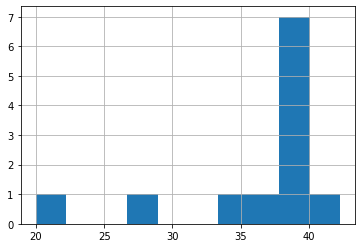

In [79]:
messages_smart_use.hist(bins=10)

In [80]:
#standart_deviation_messages_smart = np.std(messages_smart_use)
#standart_deviation_messages_smart

In [81]:
information_smart_use.pivot_table(index= 'tariff', values= 'id_messages', aggfunc= ['mean', 'var','std'])

,mean,var,std
,id_messages,id_messages,id_messages
tariff,,,
smart,38.716441,717.594201,26.787949


Как мы видим, далеко не все клиенты тарифа "Смарт" отправляют сообщения. Но те, кто это делает, за пределы лимита сильно не выходят: в среднем это 39 смс в месяц со стандартным отклонением в 27 сообщений.

##### Поговорим об интернет-трафике

In [82]:
internet_smart = information_smart.groupby('month')['mb_used'].mean()
internet_smart

month
1.0      8.735294
2.0     11.844828
3.0     15.233766
4.0     13.625000
5.0     15.907801
6.0     15.951220
7.0     15.875622
8.0     16.807692
9.0     16.392308
10.0    16.880952
11.0    17.000000
12.0    18.201780
Name: mb_used, dtype: float64

In [83]:
#internet_smart.mean()

In [84]:
#varianse_internet_smart = np.var(internet_smart)
#varianse_internet_smart  

<AxesSubplot:>

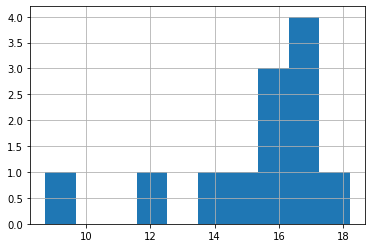

In [85]:
internet_smart.hist(bins=10)

In [86]:
#standart_deviation_internet_smart = np.std(internet_smart)
#standart_deviation_internet_smart

In [87]:
information_smart.pivot_table(index= 'tariff', values= 'mb_used', aggfunc= ['mean', 'var','std'])

,mean,var,std
,mb_used,mb_used,mb_used
tariff,,,
smart,16.336176,32.923756,5.737923


Что касается интернета, пользователям не нуужно 15 ГБ в месяц. В среднем они используют 1 ГБ с небольшим стандартным отклонением.

Вывод можно сделать следующий: тарифы надо пересматривать. Лимит по звонкам в тарифе "Ультра" превышает спрос в среднем в три раза, лимит по смс так же "раздут" в этом тарифе. У клиента может сложиться впечатление, что его заставляют платить "за воздух". Что касается интрнет трафика. то там излишки еще весомее: клиенты "Ультра" в среднем пользуются 10 ГБ из 30 предложенных, а клиенты "Смарт" вообще 1 из 10, т.е. предложение в 10 раз превышает спрос.

### Проверка гипотез.

#### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Для начала сформулируем нулевую и альтернативную гипотезы. Мы будем проверять гипотезу о равенстве средних двух генеральных совокупностей по имеющимся выборкам. Поведение клиентов с тарифом "Смарт" никак не зависит от поведения клиентов с тарифом "Ультра", так что наши совокупности независимы друг от друга.
1. H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается
2. H1: выручка пользователей тарифов «Ультра» и «Смарт» различается


Сначала сформируем необходимые нам массивы данных. Столбец с выручкой expenses в таблицах с характеристиками обоих тарифов мы уже подготовили:

In [88]:
smart = information_smart['expenses']
smart

8       1150.0
9        550.0
10       550.0
11      1150.0
12      1550.0
         ...  
3210     950.0
3211    1550.0
3212    1150.0
3213     950.0
3215     550.0
Name: expenses, Length: 2230, dtype: float64

In [89]:
ultra = information_ultra['expenses']
ultra

0       1950.0
1       1950.0
2       1950.0
3       1950.0
4       1950.0
         ...  
3205    1950.0
3206    1950.0
3207    1950.0
3208    1950.0
3214    1950.0
Name: expenses, Length: 986, dtype: float64

Так как количество клиентов с тарифом "Ультра" и тарифом "Смарт" разное, параметр equal_var установим как False.
Установим в качестве критического уровня статистической значимости alpha классическое значение в 0,05 и проверим нашу гипотезу:

In [90]:
alpha = 0.05
results = st.ttest_ind(
    smart,
    ultra,
    equal_var=False)
print('р-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось опровергнуть нулевую гипотезу')
    


р-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


Приходим к выводу, что выручка пользователей тарифов «Ультра» и «Смарт» скорее всего различается. Но мы помним, что клиентов с тарифом "Ультра" у нас гораздо больше.

#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для начала сформулируем нулевую и альтернативную гипотезы. Мы будем проверять гипотезу о равенстве средних двух генеральных совокупностей по имеющимся выборкам. Поведение клиентов из Москвы никак не зависит от поведения клиентов из других регионов, так что наши совокупности независимы друг от друга.

1. H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
2. H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сначала сформируем необходимые нам массивы данных. У нас есть общая таблица по всем клиентам с месячной выручкой information. Разобъем её на 2 части: Москва и регионы:

In [91]:
moscow = information.query('city == "Москва"')
moscow.head()

,index,user_id,month,duration,id_calls,id_messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,expenses
8,8.0,1001,11.0,430.0,59.0,NaN,18.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1150.0
9,9.0,1001,12.0,414.0,63.0,NaN,14.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,550.0
17,17.0,1003,8.0,380.0,55.0,37.0,9.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1950.0
18,18.0,1003,9.0,961.0,134.0,91.0,13.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1950.0
19,19.0,1003,10.0,855.0,108.0,83.0,15.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1950.0


In [92]:
region = information.query('city != "Москва"')
region.head()

,index,user_id,month,duration,id_calls,id_messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,expenses
0,0.0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
1,1.0,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
2,2.0,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
3,3.0,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
4,4.0,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0


Теперь сделаем срезу из этих таблиц по выручке:

In [93]:
moscow = moscow['expenses']
moscow

8       1150.0
9        550.0
17      1950.0
18      1950.0
19      1950.0
         ...  
3120     950.0
3121     550.0
3122    1750.0
3123    1350.0
3124     750.0
Name: expenses, Length: 611, dtype: float64

In [94]:
region = region['expenses']
region

0       1950.0
1       1950.0
2       1950.0
3       1950.0
4       1950.0
         ...  
3211    1550.0
3212    1150.0
3213     950.0
3214    1950.0
3215     550.0
Name: expenses, Length: 2605, dtype: float64

Так как количество клиентов из Москвы и из регионов разное, параметр equal_var установим как False. Установим в качестве критического уровня статистической значимости alpha классическое значение в 0,05 и проверим нашу гипотезу:

In [95]:
alpha = 0.05
results = st.ttest_ind(
    moscow,
    region,
    equal_var=False)
print('р-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось опровергнуть нулевую гипотезу')
    


р-значение: 0.5216952110000279
Не получилось опровергнуть нулевую гипотезу


Нулевую гипотезу мы отвергнуть не смогли, значит скорее всего жители Москвы и регионов приносят примерно одинаковую выручку.

### Общий вывод

Мы провели предварительный анализ тарифов на небольшой выборке клиентов. К каким выводам мы пришли:
1. Клиентов с тарифом "Ультра" гораздо больше, чем клиентов с тарифом "Смарт" . Это вполне объяснимо, если учесть стоимость обоих тарифов. При этом выручка от этих тарифов скорее всего различается.
2. Прибыли от клиентов из регионов и из Москвы скорее всего не отличабтся друг от друга.
3. Клиенты в обоих тарифах укладываются в лимиты по звонкам. Лимиты, можно сказать, очень большие для клиентов "Ультра" - есть смысл пересмотреть.
4. Клиенты тарифа "Смарт" выходят за пределы тарифа по количеству сообщений (не сильно, но всё же). Однако львиная доля клиентов в обоих тарифах не пользуются смс вовсе. Возможно стоит пересмотреть этот вопрос. Я предполагаю, что смс отправляют клиенты "возрастной категории". Возможно им стоит предложить тариф, в который входят смс, но остальные могут интерпретировать наличие к примеру 1000 смс в тарифе, которыми они не пользуются совсем, как желание оператора взять деньги за "воздух" - это в свою очередь может привести к оттоку клиентов.
5. Что касается интернет-трафика: клиентам обоих тарифов такие лимиты не нужны - их надо пересматривать.